# Does Evan a chance against Decker?


[Evan MacKay](evanforcambridge.com) recently announced their Campaign for State Rep in the Massachusetts 25th Middlesex district. Given the incumbent's recent unpopularity and scandal (see [the politics page](politics)) many people have expresssed excitement. However, some have questioned how feasible it is to unseat an incumbent. This page presents an analysis of demographic and fundraising data assess Evan's chances. 

```{note}
While I personally strongly support Evan over Decker this document is kept as impartial as possible. In fact originally it was originally a "brutally honest" private analysis of Evan's chances. This means that I've tried to avoid using emotional language that may influence politics when describing the data.
```

There are 4 main factors that will determine who will win this election:

1. Political positions
2. Campaign Organizing
3. Fundraising
4. Demographics of the Electorate

For this analysis I am focusing on points 3. and 4. as they are the ones where we are most well equipped to answer using data. For information on part 1 see [the politics](politics) page.


In [27]:
# %matplotlib ipympl
import glob

import matplotlib.pyplot as plt
import pandas as pd
from ma_voter_analysis.plotting import *
from ma_voter_analysis.processing import *


def find_person(
    df,
    first: str = None,
    last: str = None,
    middle: str = None,
    mid_initial_only: bool = False,
):
    idx = pd.Series(data=True, index=df.index)
    idxes = []
    if first is not None:
        idx[df["First Name"].str.upper() != first.upper()] = False
    if middle is not None:
        if mid_initial_only:
            idx[df["Middle Name"].str.upper().str[0] != middle[0].upper()] = False
        else:
            idx[df["Middle Name"].str.upper() != middle.upper()] = False
    if last is not None:
        idx[df["Last Name"].str.upper() != last.upper()] = False
    return df[idx]


def date_range(df, start, end):
    return df[(pd.to_datetime(start) < df["Date"]) & (df["Date"] < pd.to_datetime(end))]


election_date_ranges = {
    2012: ["2012-01-01", "2012-09-06"],
    2014: ["2014-01-01", "2014-09-09"],
    2016: ["2016-01-01", "2016-09-08"],
    2018: ["2018-01-01", "2018-09-04"],
    2020: ["2020-01-01", "2020-09-01"],
    2022: ["2022-01-01", "2022-09-06"],
}
# decker_exp[(pd.to_datetime('2012-01-01') < decker_exp['Date']) & (decker_exp['Date'] < pd.to_datetime('2012-09-06'))]['Amount'].sum()
# decker_exp[(pd.to_datetime('2014-01-01') < decker_exp['Date']) & (decker_exp['Date'] < pd.to_datetime('2014-09-09'))]['Amount'].sum()
YEARS = [2012, 2014, 2016, 2018, 2020, 2022]
challenger_years = [2012, 2014, 2016, 2018]

# NOTE: using 2024 for age
cur_registered_df = load_voter_list(
    "../voting/data/cambridge/general/raw/49VOT_285911.txt", date_for_age="2024-09-06"
)
cur_registered_df['Date of Registration'] = pd.to_datetime(cur_registered_df['Date of Registration'])
cur_registered_df = cur_registered_df[cur_registered_df['State Representative District'] == 142]

primary = (
    pd.read_csv("../25-middlesex/data/sept-primaries-compiled.csv",low_memory=False)
    .rename({"Unnamed: 0": "year"}, axis=1)
    .set_index(["year", "Voter ID Number"])
)
primary["Party Affiliation"] = primary["Party Affiliation"].str.strip()
general = load_full_dataset("../voting/data/cambridge/general/raw/")
general = general[general["State Representative District"] == 142]
# removing all party affliation except D and U (unaffliiated can vote in any primary)
primary = primary[primary["Party Affiliation"].isin(["D", "U"])]
general = general[general["Party Affiliation"].isin(["D", "U"])]
# convert the variable names to match with the notebook i copied from
voters = general

MUNICIPAL_YEARS = np.arange(2011, 2023, 2)
STATE_YEARS = np.arange(2012, 2023, 2)
NATIONAL_YEARS = np.arange(2012, 2023, 4)
ALL_YEARS = np.arange(2011, 2023, 1)
base_cols = [
    "First Name",
    "Middle Name",
    "Last Name",
    "age",
    "Date of Birth",
    "Date of Registration",
    "Residential Address Street Number",
    "Residential Address Street Name",
    "Residential Address Street Suffix",
    "Residential Address Apartment Number",
    "Residential Address Zip Code",
    "Mailing Address - Street Number and Name",
    "Mailing Address - Apartment Number",
    "Mailing Address - City or Town",
    "Mailing Address - State",
    "Mailing Address - Zip Code",
    "Voter Status",
    "Party Affiliation",
    "Ward Number",
    "Precinct Number",
    "State Representative District"
]
hist_cols = [
    "local_elections",
    "local_votes",
    "state_elections",
    "state_votes",
    "most_recent_local",
    "most_recent_state",
]
# mking voter history
unique_ids = voters.reset_index()["Voter ID Number"].unique()
# there must be a better way
# but idk what that would be, so here we are
most_recent_local = pd.Series(index=unique_ids)
most_recent_state = pd.Series(index=unique_ids)

for year in MUNICIPAL_YEARS:
    most_recent_local.loc[
        voters.loc[year][voters.loc[year]["voted"] == True].index
    ] = year
for year in STATE_YEARS:
    # print(year)
    most_recent_state.loc[
        voters.loc[year][voters.loc[year]["voted"] == True].index
    ] = year

new_df = (
    pd.DataFrame(
        {
            "local_elections": voters.loc[MUNICIPAL_YEARS]
            .reset_index()["Voter ID Number"]
            .value_counts(),
            "local_votes": voters.loc[MUNICIPAL_YEARS]
            .groupby("Voter ID Number")["voted"]
            .sum(),
            "state_elections": voters.loc[STATE_YEARS]
            .reset_index()["Voter ID Number"]
            .value_counts(),
            "state_votes": voters.loc[STATE_YEARS]
            .groupby("Voter ID Number")["voted"]
            .sum(),
        },
        dtype=int,
    )
    .fillna(0)
    .astype(int)
    .sort_values(["local_elections"], ascending=False)
)
most_recent_state = most_recent_state.dropna().astype(int)
most_recent_local = most_recent_local.dropna().astype(int)
new_df["most_recent_local"] = most_recent_local
new_df["most_recent_state"] = most_recent_state

cols = hist_cols + base_cols
cur_reg_hist = cur_registered_df[base_cols]
cur_reg_hist = cur_reg_hist.merge(
    new_df, left_on="Voter ID Number", right_on="Voter ID Number", how="outer"
)[cols]
cur_reg_hist.sort_values(["local_votes", "local_elections"], ascending=False)
# replace some nans with 0s to look nicer
for c in hist_cols[:4]:
    cur_reg_hist[c] = cur_reg_hist[c].fillna(0).astype(int)

# some people who voted in the past but are no longer registered will have snuck in
# do this indexing to remove them
cur_reg_hist = cur_reg_hist.loc[cur_registered_df.index]
cur_reg_hist["age"] = cur_reg_hist["age"].astype(int)
# cur_reg_hist

## Electorate Demographics



### Shift in Electorate Age


Since Decker's initial election in 2012 there has been a significant decrease in the age of the primary electorate. In 2012 voters under 40 were 21% of all voters. In 2022 they were 46%.

In [3]:

## figureing out hte numbers for above
# year = 2012
# print((primary[primary_voted_idx].loc[year]['age'] <=40).sum() / len(primary[primary_voted_idx].loc[year]))
# year = 2020
# print((primary[primary_voted_idx].loc[year]['age'] <=40).sum() / len(primary[primary_voted_idx].loc[year]))

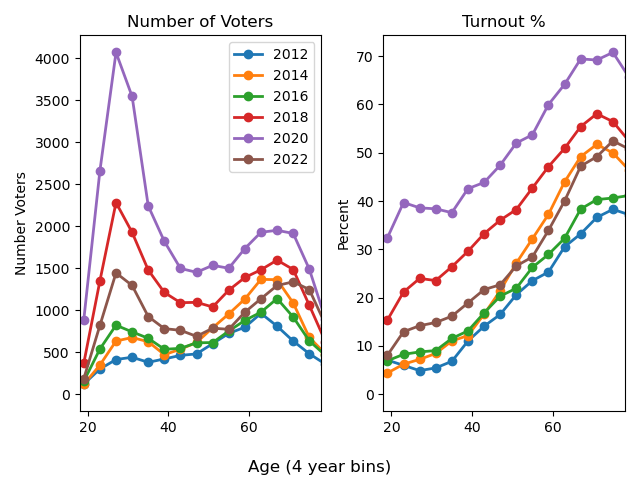

In [6]:

bin_size = 4
age_grouped = turnout_by_year_key(primary, "age", bin_size)
fig, axs = plt.subplots(1,2,)
lw = 2
for year in YEARS:
    mid_points = age_grouped.loc[year]['mid_points']
    # if year in challenger_years:
    #     lw = 4
    # else:
    #     lw = 2
    axs[0].plot(mid_points, age_grouped.loc[year]['voted'], marker='o', label=year,linewidth=lw)
    axs[1].plot(mid_points, age_grouped.loc[year]['turnout']*100, marker='o', label=year,linewidth=lw)
    # (age_grouping.loc[year]['turnout']*100).plot(marker='o', label=year, ax=axs[1])
axs[0].legend()
axs[1].set_title("Turnout %")
axs[0].set_title("Number of Voters")
axs[0].set_ylabel("Number Voters")
axs[1].set_ylabel("Percent")
axs[0].set_xlim([18, 78])
axs[1].set_xlim([18, 78])
fig.supxlabel(f"Age ({bin_size} year bins)")
plt.tight_layout()

### Voted in General but not Primary

In both 2020 and 2022 a significant portion of voters voted in the General election but did not in the Democratic primary. Of all voters eligible in the primary (Dem or Unaffiliated) 6832 in 2020 and 7050 in 2022 voted in the general but not the primary.


There is a significant population of voters 45 and under who vote in general elections, but not in primaries. 4585 in 2020 and 4115 in 2022. If more of these voters turn out for the primary then the average age will shift lower.



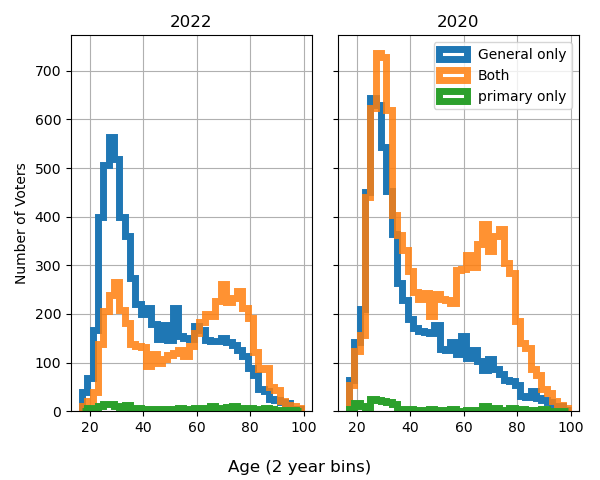

In [11]:
lw = 5
histtype = "step"
age_bin = 2
voted_nov_2020 = general.loc[2020][general.loc[2020]["voted"] == True]
voted_sep_2020 = primary.loc[2020][primary.loc[2020]["voted"] == True]
voted_nov_2022 = general.loc[2022][general.loc[2022]["voted"] == True]
voted_sep_2022 = primary.loc[2022][primary.loc[2022]["voted"] == True]
ids = set(voted_nov_2022.index).difference(voted_sep_2022.index)
ids = list(ids.intersection(general.loc[2022].index))
general_not_primary = general.loc[2022].loc[ids]

ids = set(voted_sep_2022.index).difference(voted_nov_2022.index)
ids = list(ids.intersection(general.loc[2022].index))
primary_not_general = general.loc[2022].loc[ids]

ids = set(voted_nov_2022.index).intersection(voted_sep_2022.index)
ids = list(ids.intersection(general.loc[2022].index))
both = general.loc[2022].loc[ids]


# print(len(general_not_primary))

fig, axs = plt.subplots(1, 2, figsize=(6,4.8), sharex=True, sharey=True)
bins = np.arange(17, 100, age_bin)
general_not_primary["age"].hist(
    bins=bins,
    label="General only",
    ax=axs[0],
    histtype=histtype,
    linewidth=lw,
)
both["age"].hist(
    bins=bins, label="Both", alpha=0.85, ax=axs[0], histtype=histtype, linewidth=lw
)
primary_not_general["age"].hist(
    bins=bins, label="primary only", ax=axs[0], histtype=histtype, linewidth=lw
)
axs[0].set_ylabel("Number of Voters")
axs[0].set_title("2022")


ids = set(voted_nov_2020.index).difference(voted_sep_2020.index)
ids = list(ids.intersection(general.loc[2020].index))
general_not_primary = general.loc[2020].loc[ids]

ids = set(voted_sep_2020.index).difference(voted_nov_2020.index)
ids = list(ids.intersection(general.loc[2020].index))
primary_not_general = general.loc[2020].loc[ids]

ids = set(voted_nov_2020.index).intersection(voted_sep_2020.index)
ids = list(ids.intersection(general.loc[2020].index))
both = general.loc[2020].loc[ids]
# print(len(general_not_primary))
general_not_primary["age"].hist(
    bins=bins,
    label="General only",
    ax=axs[1],
    histtype=histtype,
    linewidth=lw,
)
both["age"].hist(
    bins=bins, label="Both", alpha=0.85, ax=axs[1], histtype=histtype, linewidth=lw
)
primary_not_general["age"].hist(
    bins=bins, label="primary only", ax=axs[1], histtype=histtype, linewidth=lw
)
axs[1].legend()
fig.supxlabel(f"Age ({age_bin} year bins)")
axs[1].set_title("2020")
plt.tight_layout()

### Never had opportunity to vote for Decker

As of October 28th 2023 there were 2343 people registered to vote in the 25th Middlesex who registered after the November 2022 elections. These people have never had an opportunity to vote for Decker. These voters skew young, with a huge majority of them being under 40. These people will not have name recognition of Decker beyond the major news stories about her from last summer.

By the September 2024 primaries we can expect this number have increased as more people move to Cambridge and register, especially given the voter registration drives that will occur for the presidential primary. For example in 2020, 2445 people registered to vote in the 25th between Jan1 and 10 days before the primary.

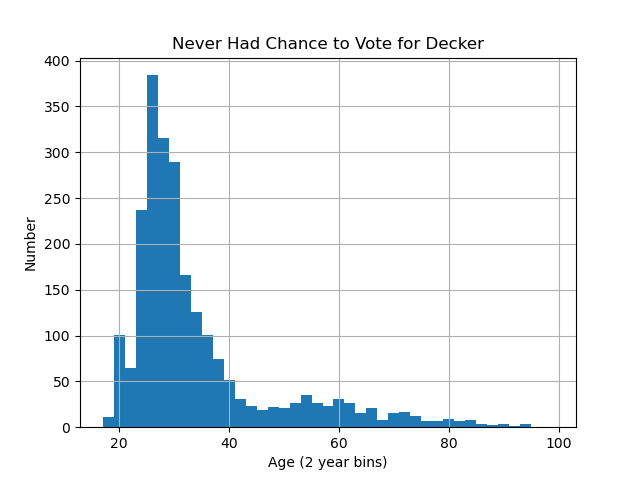

In [15]:

never_decker = cur_registered_df[cur_registered_df['Date of Registration'] > pd.to_datetime("2022-11-10")]
plt.subplots()
never_decker['age'].hist(bins=bins)
plt.title("Never Had Chance to Vote for Decker")
plt.ylabel("Number")
plt.xlabel(f"Age ({age_bin} year bins)");

In [17]:

# reg_2020 = load_voter_list(
#     "../voting/data/cambridge/49VOT_224084 november 2020 election.txt",
#     date_for_age="2020-09-01"
# )
# reg_2020['Date of Registration'] = pd.to_datetime(reg_2020['Date of Registration'])
# reg_2020 = reg_2020[reg_2020['State Representative District'] == 142]
# # people registered to vote in 2020, in time for the primary
# # print below line if you want the number
# ((reg_2020['Date of Registration'] >= pd.to_datetime('2020-01-01')) & (reg_2020['Date of Registration'] <= pd.to_datetime('2020-08-22'))).sum();

### Voters under 35 who last voted in Nov 2020

There are 4436 currently registered voters who last voted in a state election in 2020. These voters skew young, with the majority under 40. If a competitive primary motivates these voters then we can again expect the demographics to shift younger.

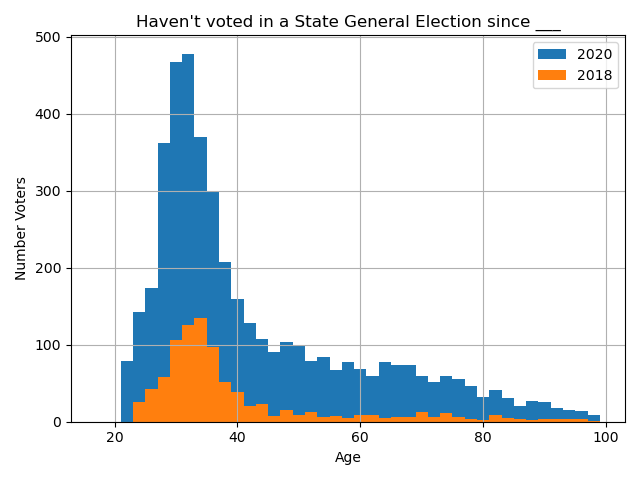

In [19]:
# print((cur_reg_hist['most_recent_state'] == 2020).sum())
plt.subplots()
plt.title("Haven't voted in a State General Election since ___")

cur_reg_hist[cur_reg_hist['most_recent_state'] == 2020]['age'].hist(bins=bins, label="2020")
cur_reg_hist[cur_reg_hist['most_recent_state'] == 2018]['age'].hist(bins=bins, label="2018")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Number Voters")
plt.tight_layout()

## Fundraising

Here we will compare the spending of Decker's prior opponents in primary elections to spending my successful challengers (e.g. Connolly vs Toomey). A takeaway here is that Decker has never faced a strong opponent, and that after raising ~\$70k a challenger is one more or less equal footing.



The following plots compare spending between candidates in an election year, starting at $0 on January 1st. This ignores the spending by incumbents in prior years which can help increase their name recognition, but is also the only reasonable way to make useful comparisons.


In [21]:
candidates = [
    "phillips",
    "decker",
    "connolly",
    "toomey",
    "uyterhoeven",
    "sharp",
    "paulino",
    "devers",
    "johnson",
]
dfs = []
for c in candidates:
    df = pd.concat(
        [
            pd.read_excel(f"../25-middlesex/data/receipts/{c}.xlsx"),
            pd.read_excel(f"../25-middlesex/data/expenditures/{c}.xlsx"),
        ],
        keys=["rec", "exp"],
    )
    df["Date"] = pd.to_datetime(df["Date"])
    dfs.append(df)
finances = pd.concat(dfs, keys=candidates)


def compare_election_spending(
    df,
    candidates: list[str] | str,
    labels: list[str] = None,
    linestyles: list[str] = None,
    ax=None,
):
    """
    df : pd.DataFrame
        Should already be set the correct date range
    candidates str
        A candidate name to be used key in the dataframe
    labels : list
        A list of str and/or None to override the default legend entries. Must
        be the same length as candidates.
    linestyles : list
        Must be same length as candidates
    ax : mpl axis, optional
    """
    if ax is None:
        ax = plt.gca()
    if isinstance(candidates, str):
        candidates = list(candidates)
    if labels is None:
        labels = [c[0].upper() + c[1:] for c in candidates]
    else:
        if len(labels) != len(candidates):
            raise ValueError("*labels* must have same length as *candidates*")
    if linestyles is None:
        linestyles = ["-"] * len(candidates)
    else:
        if len(linestyles) != len(candidates):
            raise ValueError("*linestyles* must have same length as *candidates*")
    for i, cand in enumerate(candidates):
        ax.plot(
            df.loc[cand, "exp"]["Date"][::-1].values,
            df.loc[cand, "exp"]["Amount"][::-1].cumsum(),
            lw=lw,
            linestyle=linestyles[i],
            label=labels[i],
        )
    ax.set_xlabel("Date")
    ax.set_ylabel("Total Spent")

### How much is spent to unseat an incumbent?

#### Connolly vs Toomey

Toomey arguably had higher name regonition than Decker currently does. He was a State Rep from 1993 until his defeat in 2016. In addition to that he served as Cambridge city councillor from 1989 to 2017 (concurrent with his term as a state rep for 1993->2016). 

Connolly ran in the General election for this seat in 2012 as an Independent gathering 25% of the vote. Two cycles later (2016) he competed in the democractic primary, ultimately defating toomey  2938  to 2539.


This victory came Connolly being outspent by ~$20k. This implies if the politics and campaign organization are right then even a more modest fundraising effort than the incumbent can be successful.

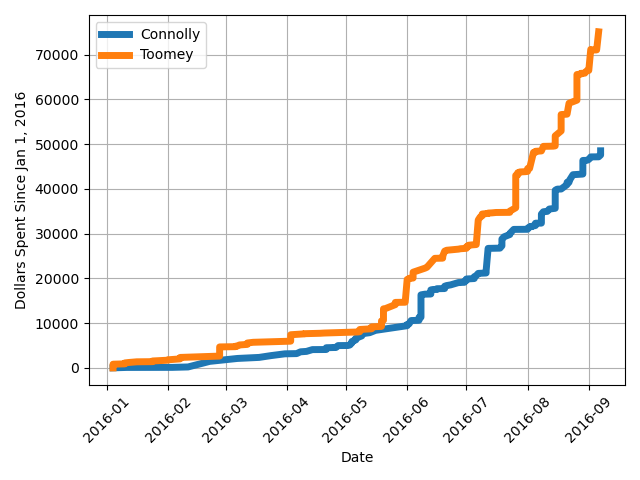

In [22]:
fig, ax = plt.subplots()
compare_election_spending(
    date_range(finances, "2016-01-01", "2016-09-08"), ["connolly", "toomey"]
)
plt.grid()

plt.ylabel("Dollars Spent Since Jan 1, 2016")
ax.tick_params(axis='x', rotation=45)
plt.legend()
plt.tight_layout()

### Paulino vs Devers

This race in 2022 is a recent example of a challenger unseating and incumbent. Paulino outspent Devers to ultimately win 1,511 to 1,350

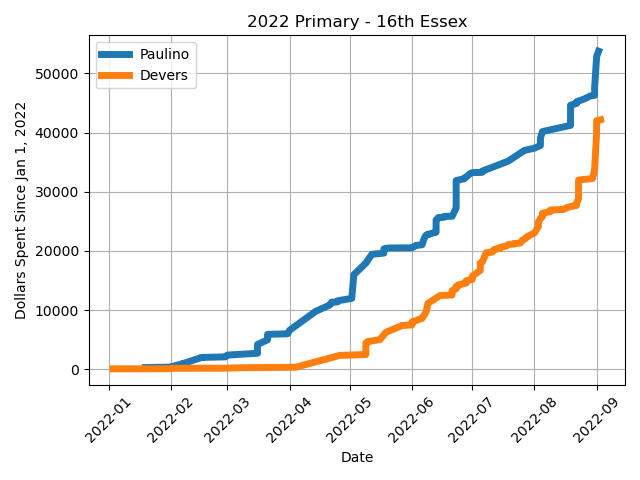

In [23]:
fig, ax = plt.subplots()
compare_election_spending(
    date_range(finances, "2022-01-01", "2022-09-06"), ["paulino", "devers"]
)
plt.grid()

plt.ylabel("Dollars Spent Since Jan 1, 2022")
plt.legend()
plt.title("2022 Primary - 16th Essex")

ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

### Decker's election bid

Decker did not unseat an incumbent, instead she ran for a seat opened up by Alice Wolf's retirement. At that point Decker had been a Cambridge city councillor for over a decade, and faced Lesley Phillips and Gayle Johnson in the Democratic primary. Despite outspending her opponents 15x (by $55k) Decker still gave up 15.7% of votes in the primary.


In [24]:
# primary_spend = df['Amount'].loc[:, 'exp'].groupby(level=0).sum()
# print(primary_spend['decker'] / (primary_spend['phillips']+primary_spend['johnson']))
# print(primary_spend['decker'] - (primary_spend['phillips']+primary_spend['johnson']))

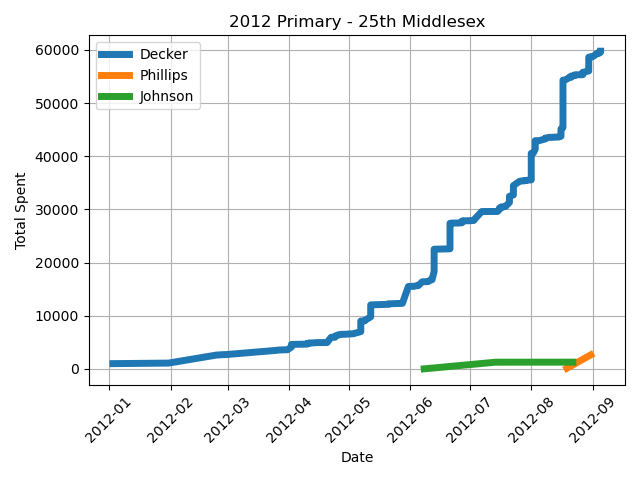

In [25]:
df = date_range(finances, "2012-01-01", "2012-9-06")
fig, ax = plt.subplots()
compare_election_spending(df, ["decker", "phillips", "johnson"])
plt.legend()
plt.grid()
plt.title("2012 Primary - 25th Middlesex")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

### Decker vs Challengers

In subsequent primaries Decker has never faced a well funded challenger with a strong ground game. Phillips challenged her in the 2014, 2016 and 2018 primaries with similarly small spending. Despite that Phillips continued to gain ~15% of voters.


Monetarily Phillips had the strongest challenge effort in 2018, spending $7200. In contrast Evan raised over ten thousand on the day their Campaign was announced.

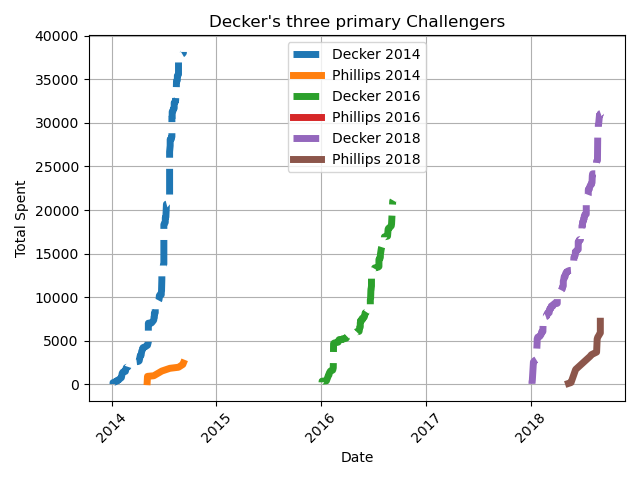

In [26]:
fig, ax = plt.subplots()
df = date_range(finances, *election_date_ranges[2014])
compare_election_spending(
    df,
    ["decker", "phillips"],
    labels=["Decker 2014", "Phillips 2014"],
    linestyles=["--", "-"],
)

df = date_range(finances, *election_date_ranges[2016])
compare_election_spending(
    df,
    ["decker", "phillips"],
    labels=["Decker 2016", "Phillips 2016"],
    linestyles=["--", "-"],
)

df = date_range(finances, *election_date_ranges[2018])
compare_election_spending(
    df,
    ["decker", "phillips"],
    labels=["Decker 2018", "Phillips 2018"],
    linestyles=["--", "-"],
)
plt.legend()
plt.grid()
plt.title("Decker's three primary Challengers")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

## Conclusions

There have been major demographics shifts in the primary electorate since Decker was elected. These shifts seem to strongly favor a progressive challenger. During this time Decker has never faced a strong challenger. Even with these weak challenges there seems to be a baseline 15% of "never Decker" voters in the district.

Despite outspending his opponent Rep Toomey was defated by the progressive challenger Connolly in 2016. So long as a candidate has politics that appeal to younger voters and manages a decent fundraising and door knocking effort they have a strong chance unseat Decker.

If Evan can raise $65k (Connolly spend adjusted for inflation) then there is a strong chance of victory.



### Donate!

If you support greater transparency in state politics and progressive reforms to improve housing, public transit, and more then I hope you will join me in donating to help Evan have a successful campaign. You can donate [here](https://secure.actblue.com/donate/ian-for-evan?refcode=can-win).
